--- Processing hdfc ---
Loaded: data/hdfc/price_data_hdfc.csv
Training BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training TCN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
Training TCN_BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

================ METRICS (Seed 29) ================

BILSTM:
  MAE : 34.6824
  MSE : 1881.3199
  RMSE: 43.3742
  R²  : 0.7864

TCN:
  MAE : 18.5245
  MSE : 530.7043
  RMSE: 23.0370
  R²  : 0.9397

TCN_BILSTM:
  MAE : 11.4024
  MSE : 205.8076
  RMSE: 14.3460
  R²  : 0.9766

Plot saved to prediction/hdfc/comparison_single_seed.png

✓ DONE — Single-seed training (seed=29) completed.


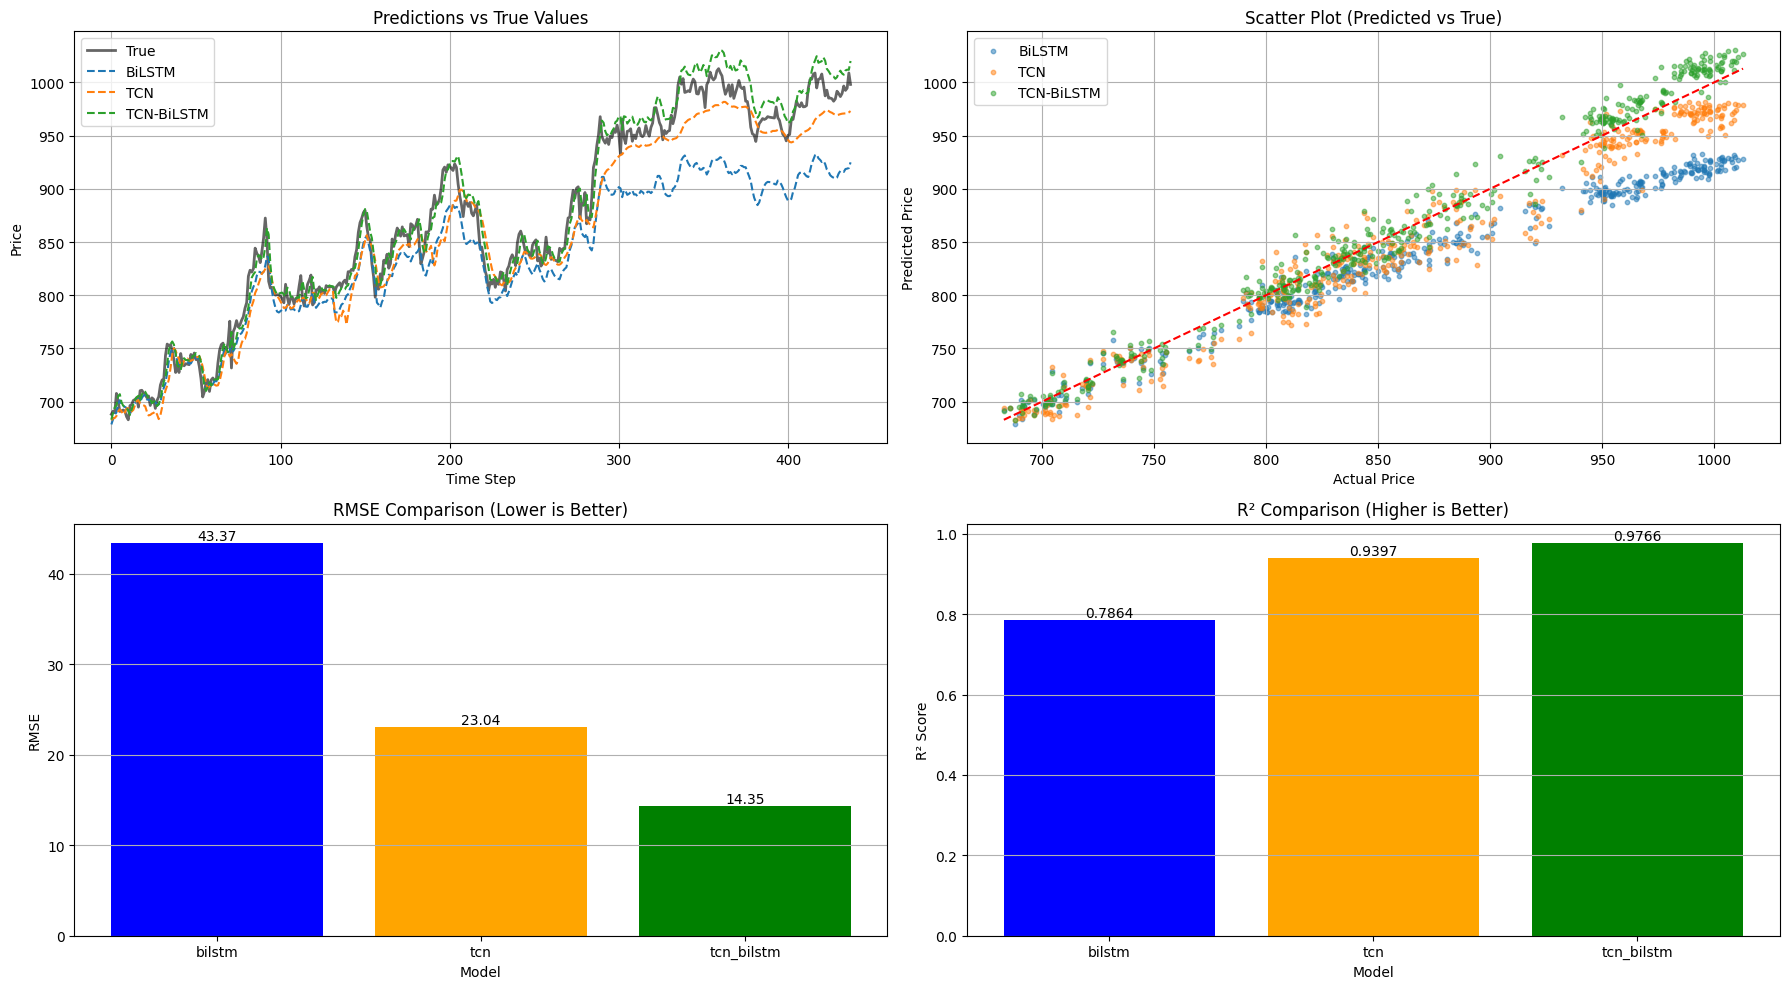

In [5]:
# NSE Stock Price Prediction Pipeline (Single Seed, No Averaging)
# Clean version — ONLY seed 29 is used
# All averaging logic removed
# Models: BiLSTM, TCN, TCN-BiLSTM trained ONCE each
# Only best-seed results and plots retained

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------
# Utility Functions
# ---------------------------------

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ---------------------------------
# File Paths
# ---------------------------------

def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    return {
        "old": f"{base}/data_harga_{s}.csv",
        "new": f"{base}/price_data_{s}.csv",
        "base": base,
    }

# ---------------------------------
# Fetch Price Data
# ---------------------------------

def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")

    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    print(f"Fetching {ticker} from yfinance: {start} -> {end}")
    t = yf.Ticker(ticker)
    try:
        df = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("Error fetching:", e)
        return pd.DataFrame()

    if df.empty:
        return df

    df = df.reset_index().rename(columns={"Date": "Date"})
    return df

# ---------------------------------
# Safe Load
# ---------------------------------

def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp["base"])

    if os.path.exists(cp["old"]):
        df = pd.read_csv(cp["old"])
        print("Loaded:", cp["old"])
        return df

    if os.path.exists(cp["new"]):
        df = pd.read_csv(cp["new"])
        print("Loaded:", cp["new"])
        return df

    df = fetch_price_yf(stock)

    if df.empty:
        print("yfinance FAILED -> generating synthetic fallback data")
        idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
        base_price = 100 + np.cumsum(np.random.randn(len(idx)) * 2)
        base_price = np.clip(base_price, 10, None)

        df = pd.DataFrame({
            "Date": idx,
            "Open": base_price * (1 + np.random.uniform(-0.02, 0.02, len(idx))),
            "High": base_price * (1 + np.random.uniform(0, 0.03, len(idx))),
            "Low": base_price * (1 - np.random.uniform(0, 0.03, len(idx))),
            "Close": base_price,
            "Volume": np.random.randint(1e6, 1e7, len(idx)),
        })
        df.to_csv(cp["new"], index=False)
        return df

    df.to_csv(cp["new"], index=False)
    return df

# ---------------------------------
# Preprocess
# ---------------------------------

def preprocess_price_data(df):
    cols = ["Open", "High", "Low", "Close", "Volume"]
    # Ensure columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Data missing columns: {missing}")

    df = df[cols].ffill().bfill()
    return df.reset_index(drop=True)

# ---------------------------------
# Windowing
# ---------------------------------

def make_windows(df, window, target_col="Close"):
    if target_col not in df.columns:
        target_col = "Close"

    cols = [target_col] + [c for c in df.columns if c != target_col]
    df = df[cols]
    data = df.values

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)


def make_tf_dataset(X, y, batch=32, shuffle=True, seed=29):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(1000, len(X)), seed=seed)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---------------------------------
# Positional Encoding
# ---------------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :tf.shape(x)[2]]

    def get_config(self):
        return super().get_config()

# ---------------------------------
# Models
# ---------------------------------

def build_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def tcn_block(x, filters, k=3, d=1, drop=0.2, final=False, seed=29):
    y = Conv1D(filters, k, padding='causal', dilation_rate=d)(x)
    y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(drop, seed=seed)(y)

    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out


def build_tcn(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = tcn_block(x, 64, 5, 1, 0.2, False, seed)
    x = tcn_block(x, 64, 3, 2, 0.2, False, seed)
    x = tcn_block(x, 32, 3, 4, 0.2, True, seed)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def build_tcn_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN Branch
    t = tcn_block(x, 32, 5, 1, 0.2, False, seed)
    t = tcn_block(t, 32, 3, 2, 0.2, True, seed)

    # BiLSTM Branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Concatenate
    c = Concatenate()([t, b])
    c = Dense(32, activation="relu")(c)
    out = Dense(1)(c)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model

# ---------------------------------
# Train Single Seed (Seed 29)
# ---------------------------------

def train_single_seed(stock, window, batch, epochs,
                      X_train_s, y_train_s, X_val_s, y_val_s,
                      X_test_s, y_test_s, target_scaler, shape):

    seed = 29
    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_s, y_train_s, batch=batch, seed=seed)
    val_ds   = make_tf_dataset(X_val_s,   y_val_s,   batch=batch, shuffle=False)

    models = {
        "bilstm": build_bilstm(shape, seed),
        "tcn": build_tcn(shape, seed),
        "tcn_bilstm": build_tcn_bilstm(shape, seed),
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name.upper()}...")
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
            ]
        )

        y_pred_s = model.predict(X_test_s)
        y_true = target_scaler.inverse_transform(y_test_s).flatten()
        y_pred = target_scaler.inverse_transform(y_pred_s).flatten()

        mse = mean_squared_error(y_true, y_pred)

        results[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse,
            "rmse": math.sqrt(mse),
            "r2": r2_score(y_true, y_pred),
        }

    return models, results

# ---------------------------------
# Plotting (No Averaging)
# ---------------------------------

def plot_results(results, stock):
    # Print metrics clearly
    print("\n================ METRICS (Seed 29) ================")
    for name, r in results.items():
        print(f"\n{name.upper()}:")
        print(f"  MAE : {r['mae']:.4f}")
        print(f"  MSE : {r['mse']:.4f}")
        print(f"  RMSE: {r['rmse']:.4f}")
        print(f"  R²  : {r['r2']:.4f}")
    print("===================================================\n")

    # Fixed syntax here: removed double parens and trailing strings
    plt.figure(figsize=(18, 10))
    y_true = results["bilstm"]["y_true"] # All models share the same y_true

    # Time series
    ax = plt.subplot(2, 2, 1)
    ax.plot(y_true, label="True", linewidth=2, color='black', alpha=0.6)
    ax.plot(results["bilstm"]["y_pred"], label="BiLSTM", linestyle='--')
    ax.plot(results["tcn"]["y_pred"], label="TCN", linestyle='--')
    ax.plot(results["tcn_bilstm"]["y_pred"], label="TCN-BiLSTM", linestyle='--')
    ax.set_title("Predictions vs True Values")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

    # Scatter
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(y_true, results["bilstm"]["y_pred"], alpha=0.5, label="BiLSTM", s=10)
    ax2.scatter(y_true, results["tcn"]["y_pred"], alpha=0.5, label="TCN", s=10)
    ax2.scatter(y_true, results["tcn_bilstm"]["y_pred"], alpha=0.5, label="TCN-BiLSTM", s=10)
    lim = [y_true.min(), y_true.max()]
    ax2.plot(lim, lim, 'r--')
    ax2.set_title("Scatter Plot (Predicted vs True)")
    ax2.set_xlabel("Actual Price")
    ax2.set_ylabel("Predicted Price")
    ax2.legend()
    ax2.grid(True)

    # RMSE bar
    ax3 = plt.subplot(2, 2, 3)
    models = ["bilstm", "tcn", "tcn_bilstm"]
    rmse_vals = [results[m]["rmse"] for m in models]
    bars = ax3.bar(models, rmse_vals, color=['blue', 'orange', 'green'])
    ax3.bar_label(bars, fmt='%.2f')
    ax3.set_title("RMSE Comparison (Lower is Better)")
    ax3.set_xlabel("Model")
    ax3.set_ylabel("RMSE")
    ax3.grid(True, axis='y')

    # R² bar
    ax4 = plt.subplot(2, 2, 4)
    r2_vals = [results[m]["r2"] for m in models]
    bars = ax4.bar(models, r2_vals, color=['blue', 'orange', 'green'])
    ax4.bar_label(bars, fmt='%.4f')
    ax4.set_title("R² Comparison (Higher is Better)")
    ax4.set_xlabel("Model")
    ax4.set_ylabel("R² Score")
    ax4.grid(True, axis='y')

    plt.tight_layout()
    ensure_dir(f"prediction/{stock}")
    plt.savefig(f"prediction/{stock}/comparison_single_seed.png", dpi=300)
    print(f"Plot saved to prediction/{stock}/comparison_single_seed.png")
    # plt.show() # Commented out for non-interactive envs

# ---------------------------------
# Main
# ---------------------------------

if __name__ == "__main__":
    STOCKS = ["hdfc"]
    WINDOW = 20
    BATCH = 32
    EPOCHS = 200

    for stock in STOCKS:
        print(f"--- Processing {stock} ---")
        df = safe_load_price(stock)
        df = preprocess_price_data(df)

        ensure_dir(f"prediction/{stock}")
        ensure_dir(f"saved_models/{stock}")

        X, y = make_windows(df, WINDOW)

        n = len(X)
        t1 = int(0.7 * n)
        t2 = int(0.85 * n)

        X_train, y_train = X[:t1], y[:t1]
        X_val,   y_val    = X[t1:t2], y[t1:t2]
        X_test,  y_test   = X[t2:],   y[t2:]

        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        X_train_s = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        y_train_s = target_scaler.fit_transform(y_train)

        X_val_s = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        y_val_s = target_scaler.transform(y_val)

        X_test_s = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        y_test_s = target_scaler.transform(y_test)

        shape = (WINDOW, X.shape[2])

        models, results = train_single_seed(
            stock, WINDOW, BATCH, EPOCHS,
            X_train_s, y_train_s, X_val_s, y_val_s,
            X_test_s, y_test_s, target_scaler, shape
        )

        # Save models
        for name, model in models.items():
            save_path = f"saved_models/{stock}/{name}_seed29"
            ensure_dir(save_path)
            model.save(f"{save_path}/model.keras")

        # Save predictions
        for name, r in results.items():
            pd.DataFrame({
                "y_true": r["y_true"],
                "y_pred": r["y_pred"]
            }).to_csv(f"prediction/{stock}/{name}_predictions_seed29.csv", index=False)

        plot_results(results, stock)

    print("\n✓ DONE — Single-seed training (seed=29) completed.")

--- Processing infosys ---
Fetching INFY.NS from yfinance: 2014-01-01 -> 2025-11-23
Training BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training TCN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Training TCN_BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

================ METRICS (Seed 29) ================

BILSTM:
  MAE : 45.8237
  MSE : 3703.7253
  RMSE: 60.8582
  R²  : 0.8786

TCN:
  MAE : 32.2748
  MSE : 1731.1920
  RMSE: 41.6076
  R²  : 0.9433

TCN_BILSTM:
  MAE : 21.2897
  MSE : 795.4849
  RMSE: 28.2043
  R²  : 0.9739

Plot saved to prediction/infosys/comparison_single_seed.png

✓ DONE — Single-seed training (seed=29) completed.


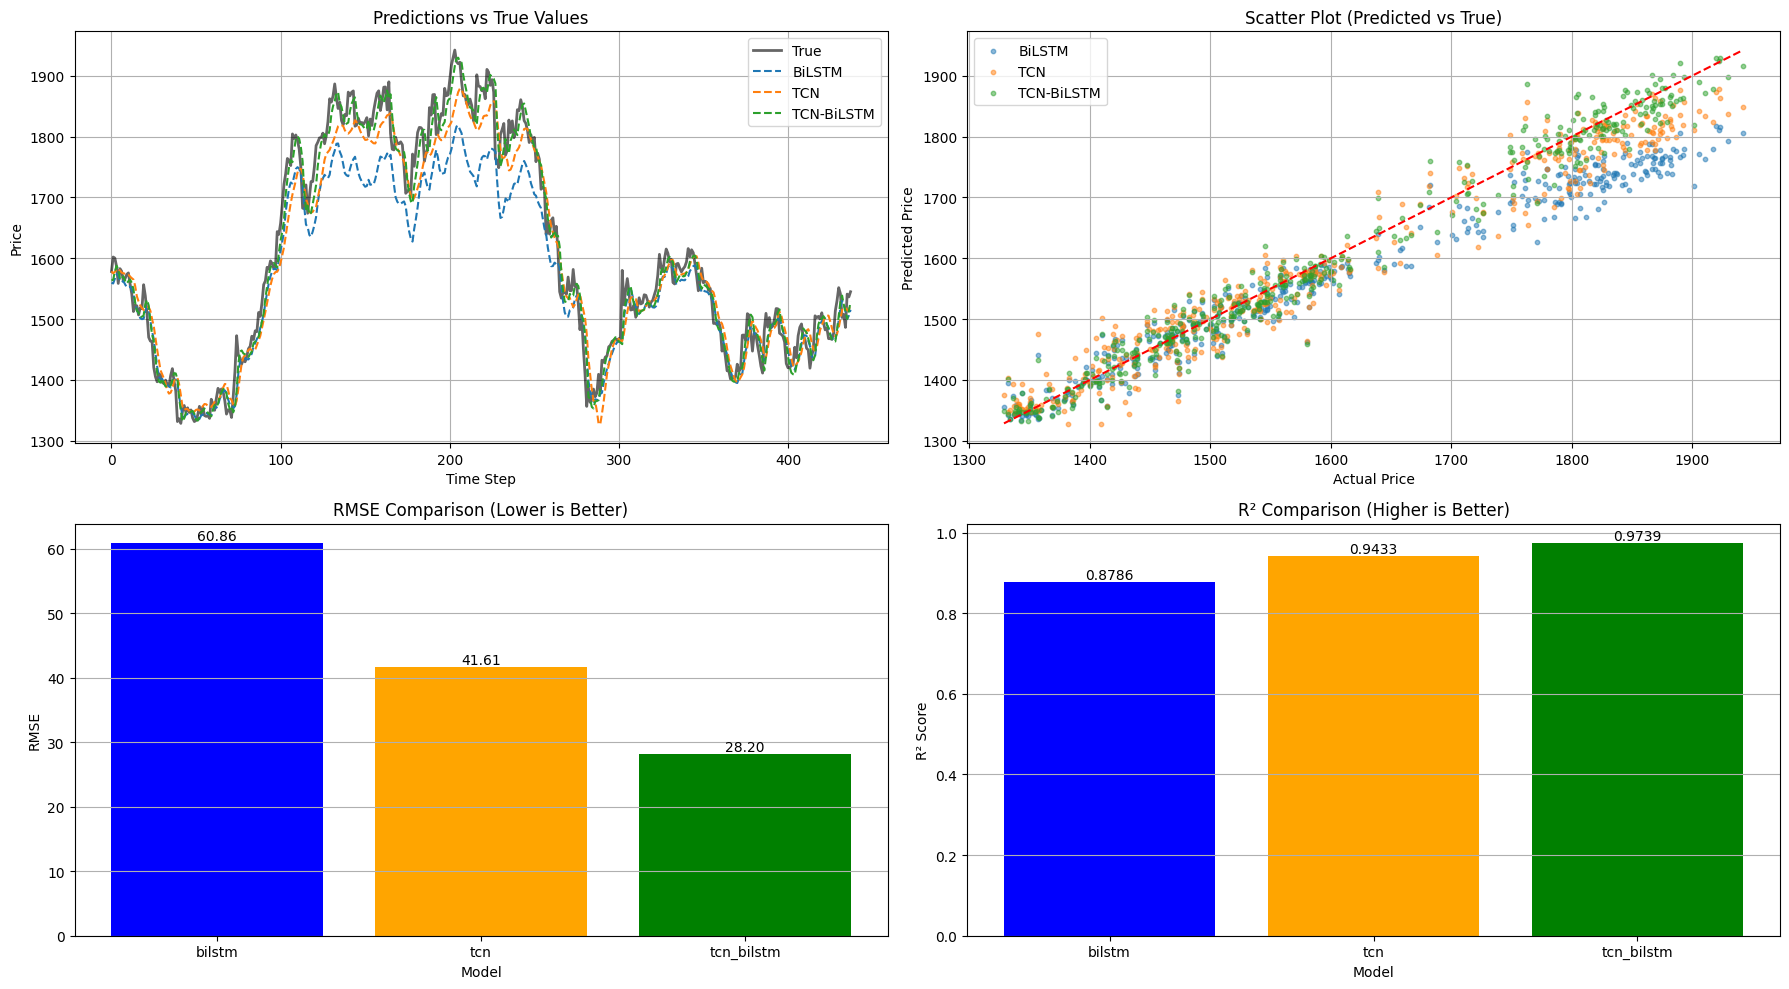

In [6]:
# NSE Stock Price Prediction Pipeline (Single Seed, No Averaging)
# Clean version — ONLY seed 29 is used
# All averaging logic removed
# Models: BiLSTM, TCN, TCN-BiLSTM trained ONCE each
# Only best-seed results and plots retained

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------
# Utility Functions
# ---------------------------------

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ---------------------------------
# File Paths
# ---------------------------------

def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    return {
        "old": f"{base}/data_harga_{s}.csv",
        "new": f"{base}/price_data_{s}.csv",
        "base": base,
    }

# ---------------------------------
# Fetch Price Data
# ---------------------------------

def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")

    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    print(f"Fetching {ticker} from yfinance: {start} -> {end}")
    t = yf.Ticker(ticker)
    try:
        df = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("Error fetching:", e)
        return pd.DataFrame()

    if df.empty:
        return df

    df = df.reset_index().rename(columns={"Date": "Date"})
    return df

# ---------------------------------
# Safe Load
# ---------------------------------

def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp["base"])

    if os.path.exists(cp["old"]):
        df = pd.read_csv(cp["old"])
        print("Loaded:", cp["old"])
        return df

    if os.path.exists(cp["new"]):
        df = pd.read_csv(cp["new"])
        print("Loaded:", cp["new"])
        return df

    df = fetch_price_yf(stock)

    if df.empty:
        print("yfinance FAILED -> generating synthetic fallback data")
        idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
        base_price = 100 + np.cumsum(np.random.randn(len(idx)) * 2)
        base_price = np.clip(base_price, 10, None)

        df = pd.DataFrame({
            "Date": idx,
            "Open": base_price * (1 + np.random.uniform(-0.02, 0.02, len(idx))),
            "High": base_price * (1 + np.random.uniform(0, 0.03, len(idx))),
            "Low": base_price * (1 - np.random.uniform(0, 0.03, len(idx))),
            "Close": base_price,
            "Volume": np.random.randint(1e6, 1e7, len(idx)),
        })
        df.to_csv(cp["new"], index=False)
        return df

    df.to_csv(cp["new"], index=False)
    return df

# ---------------------------------
# Preprocess
# ---------------------------------

def preprocess_price_data(df):
    cols = ["Open", "High", "Low", "Close", "Volume"]
    # Ensure columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Data missing columns: {missing}")

    df = df[cols].ffill().bfill()
    return df.reset_index(drop=True)

# ---------------------------------
# Windowing
# ---------------------------------

def make_windows(df, window, target_col="Close"):
    if target_col not in df.columns:
        target_col = "Close"

    cols = [target_col] + [c for c in df.columns if c != target_col]
    df = df[cols]
    data = df.values

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)


def make_tf_dataset(X, y, batch=32, shuffle=True, seed=29):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(1000, len(X)), seed=seed)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---------------------------------
# Positional Encoding
# ---------------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :tf.shape(x)[2]]

    def get_config(self):
        return super().get_config()

# ---------------------------------
# Models
# ---------------------------------

def build_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def tcn_block(x, filters, k=3, d=1, drop=0.2, final=False, seed=29):
    y = Conv1D(filters, k, padding='causal', dilation_rate=d)(x)
    y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(drop, seed=seed)(y)

    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out


def build_tcn(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = tcn_block(x, 64, 5, 1, 0.2, False, seed)
    x = tcn_block(x, 64, 3, 2, 0.2, False, seed)
    x = tcn_block(x, 32, 3, 4, 0.2, True, seed)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def build_tcn_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN Branch
    t = tcn_block(x, 32, 5, 1, 0.2, False, seed)
    t = tcn_block(t, 32, 3, 2, 0.2, True, seed)

    # BiLSTM Branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Concatenate
    c = Concatenate()([t, b])
    c = Dense(32, activation="relu")(c)
    out = Dense(1)(c)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model

# ---------------------------------
# Train Single Seed (Seed 29)
# ---------------------------------

def train_single_seed(stock, window, batch, epochs,
                      X_train_s, y_train_s, X_val_s, y_val_s,
                      X_test_s, y_test_s, target_scaler, shape):

    seed = 29
    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_s, y_train_s, batch=batch, seed=seed)
    val_ds   = make_tf_dataset(X_val_s,   y_val_s,   batch=batch, shuffle=False)

    models = {
        "bilstm": build_bilstm(shape, seed),
        "tcn": build_tcn(shape, seed),
        "tcn_bilstm": build_tcn_bilstm(shape, seed),
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name.upper()}...")
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
            ]
        )

        y_pred_s = model.predict(X_test_s)
        y_true = target_scaler.inverse_transform(y_test_s).flatten()
        y_pred = target_scaler.inverse_transform(y_pred_s).flatten()

        mse = mean_squared_error(y_true, y_pred)

        results[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse,
            "rmse": math.sqrt(mse),
            "r2": r2_score(y_true, y_pred),
        }

    return models, results

# ---------------------------------
# Plotting (No Averaging)
# ---------------------------------

def plot_results(results, stock):
    # Print metrics clearly
    print("\n================ METRICS (Seed 29) ================")
    for name, r in results.items():
        print(f"\n{name.upper()}:")
        print(f"  MAE : {r['mae']:.4f}")
        print(f"  MSE : {r['mse']:.4f}")
        print(f"  RMSE: {r['rmse']:.4f}")
        print(f"  R²  : {r['r2']:.4f}")
    print("===================================================\n")

    # Fixed syntax here: removed double parens and trailing strings
    plt.figure(figsize=(18, 10))
    y_true = results["bilstm"]["y_true"] # All models share the same y_true

    # Time series
    ax = plt.subplot(2, 2, 1)
    ax.plot(y_true, label="True", linewidth=2, color='black', alpha=0.6)
    ax.plot(results["bilstm"]["y_pred"], label="BiLSTM", linestyle='--')
    ax.plot(results["tcn"]["y_pred"], label="TCN", linestyle='--')
    ax.plot(results["tcn_bilstm"]["y_pred"], label="TCN-BiLSTM", linestyle='--')
    ax.set_title("Predictions vs True Values")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

    # Scatter
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(y_true, results["bilstm"]["y_pred"], alpha=0.5, label="BiLSTM", s=10)
    ax2.scatter(y_true, results["tcn"]["y_pred"], alpha=0.5, label="TCN", s=10)
    ax2.scatter(y_true, results["tcn_bilstm"]["y_pred"], alpha=0.5, label="TCN-BiLSTM", s=10)
    lim = [y_true.min(), y_true.max()]
    ax2.plot(lim, lim, 'r--')
    ax2.set_title("Scatter Plot (Predicted vs True)")
    ax2.set_xlabel("Actual Price")
    ax2.set_ylabel("Predicted Price")
    ax2.legend()
    ax2.grid(True)

    # RMSE bar
    ax3 = plt.subplot(2, 2, 3)
    models = ["bilstm", "tcn", "tcn_bilstm"]
    rmse_vals = [results[m]["rmse"] for m in models]
    bars = ax3.bar(models, rmse_vals, color=['blue', 'orange', 'green'])
    ax3.bar_label(bars, fmt='%.2f')
    ax3.set_title("RMSE Comparison (Lower is Better)")
    ax3.set_xlabel("Model")
    ax3.set_ylabel("RMSE")
    ax3.grid(True, axis='y')

    # R² bar
    ax4 = plt.subplot(2, 2, 4)
    r2_vals = [results[m]["r2"] for m in models]
    bars = ax4.bar(models, r2_vals, color=['blue', 'orange', 'green'])
    ax4.bar_label(bars, fmt='%.4f')
    ax4.set_title("R² Comparison (Higher is Better)")
    ax4.set_xlabel("Model")
    ax4.set_ylabel("R² Score")
    ax4.grid(True, axis='y')

    plt.tight_layout()
    ensure_dir(f"prediction/{stock}")
    plt.savefig(f"prediction/{stock}/comparison_single_seed.png", dpi=300)
    print(f"Plot saved to prediction/{stock}/comparison_single_seed.png")
    # plt.show() # Commented out for non-interactive envs

# ---------------------------------
# Main
# ---------------------------------

if __name__ == "__main__":
    STOCKS = ["infosys"]
    WINDOW = 20
    BATCH = 32
    EPOCHS = 200

    for stock in STOCKS:
        print(f"--- Processing {stock} ---")
        df = safe_load_price(stock)
        df = preprocess_price_data(df)

        ensure_dir(f"prediction/{stock}")
        ensure_dir(f"saved_models/{stock}")

        X, y = make_windows(df, WINDOW)

        n = len(X)
        t1 = int(0.7 * n)
        t2 = int(0.85 * n)

        X_train, y_train = X[:t1], y[:t1]
        X_val,   y_val    = X[t1:t2], y[t1:t2]
        X_test,  y_test   = X[t2:],   y[t2:]

        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        X_train_s = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        y_train_s = target_scaler.fit_transform(y_train)

        X_val_s = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        y_val_s = target_scaler.transform(y_val)

        X_test_s = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        y_test_s = target_scaler.transform(y_test)

        shape = (WINDOW, X.shape[2])

        models, results = train_single_seed(
            stock, WINDOW, BATCH, EPOCHS,
            X_train_s, y_train_s, X_val_s, y_val_s,
            X_test_s, y_test_s, target_scaler, shape
        )

        # Save models
        for name, model in models.items():
            save_path = f"saved_models/{stock}/{name}_seed29"
            ensure_dir(save_path)
            model.save(f"{save_path}/model.keras")

        # Save predictions
        for name, r in results.items():
            pd.DataFrame({
                "y_true": r["y_true"],
                "y_pred": r["y_pred"]
            }).to_csv(f"prediction/{stock}/{name}_predictions_seed29.csv", index=False)

        plot_results(results, stock)

    print("\n✓ DONE — Single-seed training (seed=29) completed.")

--- Processing tcs ---
Fetching TCS.NS from yfinance: 2014-01-01 -> 2025-11-23
Training BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Training TCN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Training TCN_BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

================ METRICS (Seed 29) ================

BILSTM:
  MAE : 84.3034
  MSE : 11784.2490
  RMSE: 108.5553
  R²  : 0.9308

TCN:
  MAE : 88.2726
  MSE : 13633.5352
  RMSE: 116.7627
  R²  : 0.9199

TCN_BILSTM:
  MAE : 63.7515
  MSE : 7205.6851
  RMSE: 84.8863
  R²  : 0.9577

Plot saved to prediction/tcs/comparison_single_seed.png

✓ DONE — Single-seed training (seed=29) completed.


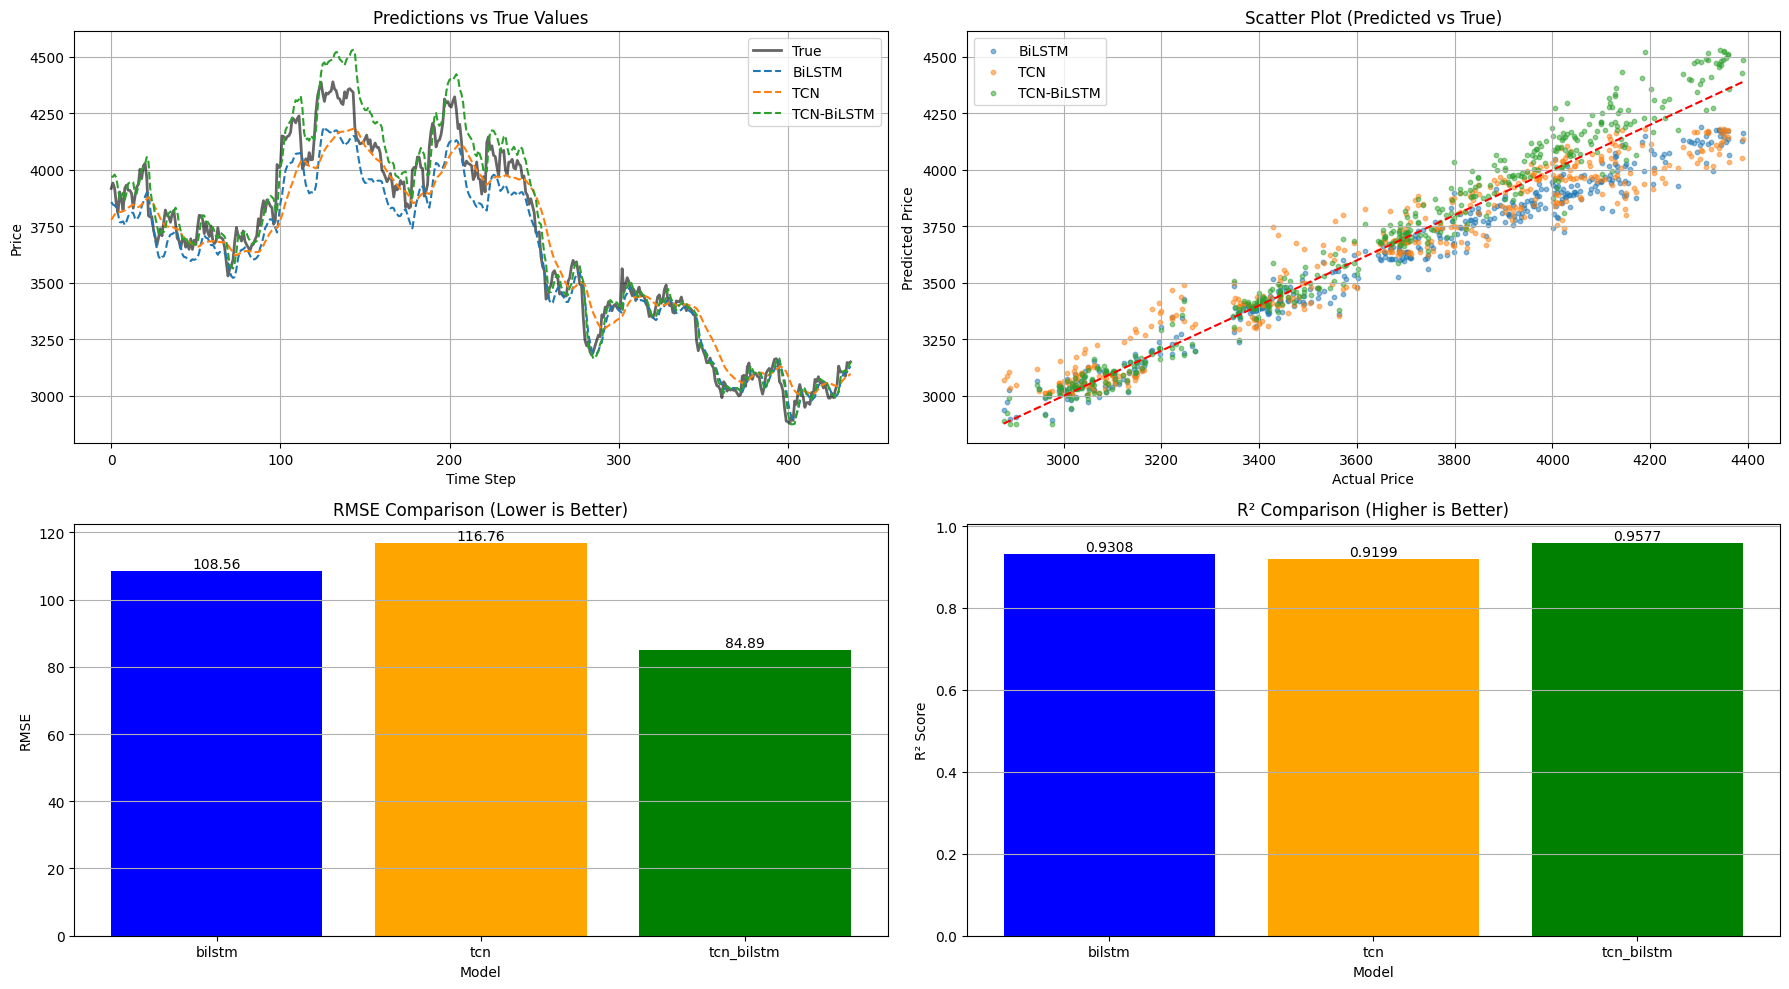

In [7]:
# NSE Stock Price Prediction Pipeline (Single Seed, No Averaging)
# Clean version — ONLY seed 29 is used
# All averaging logic removed
# Models: BiLSTM, TCN, TCN-BiLSTM trained ONCE each
# Only best-seed results and plots retained

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------
# Utility Functions
# ---------------------------------

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ---------------------------------
# File Paths
# ---------------------------------

def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    return {
        "old": f"{base}/data_harga_{s}.csv",
        "new": f"{base}/price_data_{s}.csv",
        "base": base,
    }

# ---------------------------------
# Fetch Price Data
# ---------------------------------

def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")

    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    print(f"Fetching {ticker} from yfinance: {start} -> {end}")
    t = yf.Ticker(ticker)
    try:
        df = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("Error fetching:", e)
        return pd.DataFrame()

    if df.empty:
        return df

    df = df.reset_index().rename(columns={"Date": "Date"})
    return df

# ---------------------------------
# Safe Load
# ---------------------------------

def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp["base"])

    if os.path.exists(cp["old"]):
        df = pd.read_csv(cp["old"])
        print("Loaded:", cp["old"])
        return df

    if os.path.exists(cp["new"]):
        df = pd.read_csv(cp["new"])
        print("Loaded:", cp["new"])
        return df

    df = fetch_price_yf(stock)

    if df.empty:
        print("yfinance FAILED -> generating synthetic fallback data")
        idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
        base_price = 100 + np.cumsum(np.random.randn(len(idx)) * 2)
        base_price = np.clip(base_price, 10, None)

        df = pd.DataFrame({
            "Date": idx,
            "Open": base_price * (1 + np.random.uniform(-0.02, 0.02, len(idx))),
            "High": base_price * (1 + np.random.uniform(0, 0.03, len(idx))),
            "Low": base_price * (1 - np.random.uniform(0, 0.03, len(idx))),
            "Close": base_price,
            "Volume": np.random.randint(1e6, 1e7, len(idx)),
        })
        df.to_csv(cp["new"], index=False)
        return df

    df.to_csv(cp["new"], index=False)
    return df

# ---------------------------------
# Preprocess
# ---------------------------------

def preprocess_price_data(df):
    cols = ["Open", "High", "Low", "Close", "Volume"]
    # Ensure columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Data missing columns: {missing}")

    df = df[cols].ffill().bfill()
    return df.reset_index(drop=True)

# ---------------------------------
# Windowing
# ---------------------------------

def make_windows(df, window, target_col="Close"):
    if target_col not in df.columns:
        target_col = "Close"

    cols = [target_col] + [c for c in df.columns if c != target_col]
    df = df[cols]
    data = df.values

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)


def make_tf_dataset(X, y, batch=32, shuffle=True, seed=29):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(1000, len(X)), seed=seed)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---------------------------------
# Positional Encoding
# ---------------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :tf.shape(x)[2]]

    def get_config(self):
        return super().get_config()

# ---------------------------------
# Models
# ---------------------------------

def build_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def tcn_block(x, filters, k=3, d=1, drop=0.2, final=False, seed=29):
    y = Conv1D(filters, k, padding='causal', dilation_rate=d)(x)
    y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(drop, seed=seed)(y)

    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out


def build_tcn(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = tcn_block(x, 64, 5, 1, 0.2, False, seed)
    x = tcn_block(x, 64, 3, 2, 0.2, False, seed)
    x = tcn_block(x, 32, 3, 4, 0.2, True, seed)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def build_tcn_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN Branch
    t = tcn_block(x, 32, 5, 1, 0.2, False, seed)
    t = tcn_block(t, 32, 3, 2, 0.2, True, seed)

    # BiLSTM Branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Concatenate
    c = Concatenate()([t, b])
    c = Dense(32, activation="relu")(c)
    out = Dense(1)(c)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model

# ---------------------------------
# Train Single Seed (Seed 29)
# ---------------------------------

def train_single_seed(stock, window, batch, epochs,
                      X_train_s, y_train_s, X_val_s, y_val_s,
                      X_test_s, y_test_s, target_scaler, shape):

    seed = 29
    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_s, y_train_s, batch=batch, seed=seed)
    val_ds   = make_tf_dataset(X_val_s,   y_val_s,   batch=batch, shuffle=False)

    models = {
        "bilstm": build_bilstm(shape, seed),
        "tcn": build_tcn(shape, seed),
        "tcn_bilstm": build_tcn_bilstm(shape, seed),
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name.upper()}...")
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
            ]
        )

        y_pred_s = model.predict(X_test_s)
        y_true = target_scaler.inverse_transform(y_test_s).flatten()
        y_pred = target_scaler.inverse_transform(y_pred_s).flatten()

        mse = mean_squared_error(y_true, y_pred)

        results[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse,
            "rmse": math.sqrt(mse),
            "r2": r2_score(y_true, y_pred),
        }

    return models, results

# ---------------------------------
# Plotting (No Averaging)
# ---------------------------------

def plot_results(results, stock):
    # Print metrics clearly
    print("\n================ METRICS (Seed 29) ================")
    for name, r in results.items():
        print(f"\n{name.upper()}:")
        print(f"  MAE : {r['mae']:.4f}")
        print(f"  MSE : {r['mse']:.4f}")
        print(f"  RMSE: {r['rmse']:.4f}")
        print(f"  R²  : {r['r2']:.4f}")
    print("===================================================\n")

    # Fixed syntax here: removed double parens and trailing strings
    plt.figure(figsize=(18, 10))
    y_true = results["bilstm"]["y_true"] # All models share the same y_true

    # Time series
    ax = plt.subplot(2, 2, 1)
    ax.plot(y_true, label="True", linewidth=2, color='black', alpha=0.6)
    ax.plot(results["bilstm"]["y_pred"], label="BiLSTM", linestyle='--')
    ax.plot(results["tcn"]["y_pred"], label="TCN", linestyle='--')
    ax.plot(results["tcn_bilstm"]["y_pred"], label="TCN-BiLSTM", linestyle='--')
    ax.set_title("Predictions vs True Values")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

    # Scatter
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(y_true, results["bilstm"]["y_pred"], alpha=0.5, label="BiLSTM", s=10)
    ax2.scatter(y_true, results["tcn"]["y_pred"], alpha=0.5, label="TCN", s=10)
    ax2.scatter(y_true, results["tcn_bilstm"]["y_pred"], alpha=0.5, label="TCN-BiLSTM", s=10)
    lim = [y_true.min(), y_true.max()]
    ax2.plot(lim, lim, 'r--')
    ax2.set_title("Scatter Plot (Predicted vs True)")
    ax2.set_xlabel("Actual Price")
    ax2.set_ylabel("Predicted Price")
    ax2.legend()
    ax2.grid(True)

    # RMSE bar
    ax3 = plt.subplot(2, 2, 3)
    models = ["bilstm", "tcn", "tcn_bilstm"]
    rmse_vals = [results[m]["rmse"] for m in models]
    bars = ax3.bar(models, rmse_vals, color=['blue', 'orange', 'green'])
    ax3.bar_label(bars, fmt='%.2f')
    ax3.set_title("RMSE Comparison (Lower is Better)")
    ax3.set_xlabel("Model")
    ax3.set_ylabel("RMSE")
    ax3.grid(True, axis='y')

    # R² bar
    ax4 = plt.subplot(2, 2, 4)
    r2_vals = [results[m]["r2"] for m in models]
    bars = ax4.bar(models, r2_vals, color=['blue', 'orange', 'green'])
    ax4.bar_label(bars, fmt='%.4f')
    ax4.set_title("R² Comparison (Higher is Better)")
    ax4.set_xlabel("Model")
    ax4.set_ylabel("R² Score")
    ax4.grid(True, axis='y')

    plt.tight_layout()
    ensure_dir(f"prediction/{stock}")
    plt.savefig(f"prediction/{stock}/comparison_single_seed.png", dpi=300)
    print(f"Plot saved to prediction/{stock}/comparison_single_seed.png")
    # plt.show() # Commented out for non-interactive envs

# ---------------------------------
# Main
# ---------------------------------

if __name__ == "__main__":
    STOCKS = ["tcs"]
    WINDOW = 20
    BATCH = 32
    EPOCHS = 200

    for stock in STOCKS:
        print(f"--- Processing {stock} ---")
        df = safe_load_price(stock)
        df = preprocess_price_data(df)

        ensure_dir(f"prediction/{stock}")
        ensure_dir(f"saved_models/{stock}")

        X, y = make_windows(df, WINDOW)

        n = len(X)
        t1 = int(0.7 * n)
        t2 = int(0.85 * n)

        X_train, y_train = X[:t1], y[:t1]
        X_val,   y_val    = X[t1:t2], y[t1:t2]
        X_test,  y_test   = X[t2:],   y[t2:]

        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        X_train_s = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        y_train_s = target_scaler.fit_transform(y_train)

        X_val_s = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        y_val_s = target_scaler.transform(y_val)

        X_test_s = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        y_test_s = target_scaler.transform(y_test)

        shape = (WINDOW, X.shape[2])

        models, results = train_single_seed(
            stock, WINDOW, BATCH, EPOCHS,
            X_train_s, y_train_s, X_val_s, y_val_s,
            X_test_s, y_test_s, target_scaler, shape
        )

        # Save models
        for name, model in models.items():
            save_path = f"saved_models/{stock}/{name}_seed29"
            ensure_dir(save_path)
            model.save(f"{save_path}/model.keras")

        # Save predictions
        for name, r in results.items():
            pd.DataFrame({
                "y_true": r["y_true"],
                "y_pred": r["y_pred"]
            }).to_csv(f"prediction/{stock}/{name}_predictions_seed29.csv", index=False)

        plot_results(results, stock)

    print("\n✓ DONE — Single-seed training (seed=29) completed.")

--- Processing reliance ---
Fetching RELIANCE.NS from yfinance: 2014-01-01 -> 2025-11-23
Training BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Training TCN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Training TCN_BILSTM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

================ METRICS (Seed 29) ================

BILSTM:
  MAE : 29.3860
  MSE : 1252.1454
  RMSE: 35.3857
  R²  : 0.8746

TCN:
  MAE : 27.4483
  MSE : 1208.0374
  RMSE: 34.7568
  R²  : 0.8791

TCN_BILSTM:
  MAE : 23.4853
  MSE : 869.0037
  RMSE: 29.4789
  R²  : 0.9130

Plot saved to prediction/reliance/comparison_single_seed.png

✓ DONE — Single-seed training (seed=29) completed.


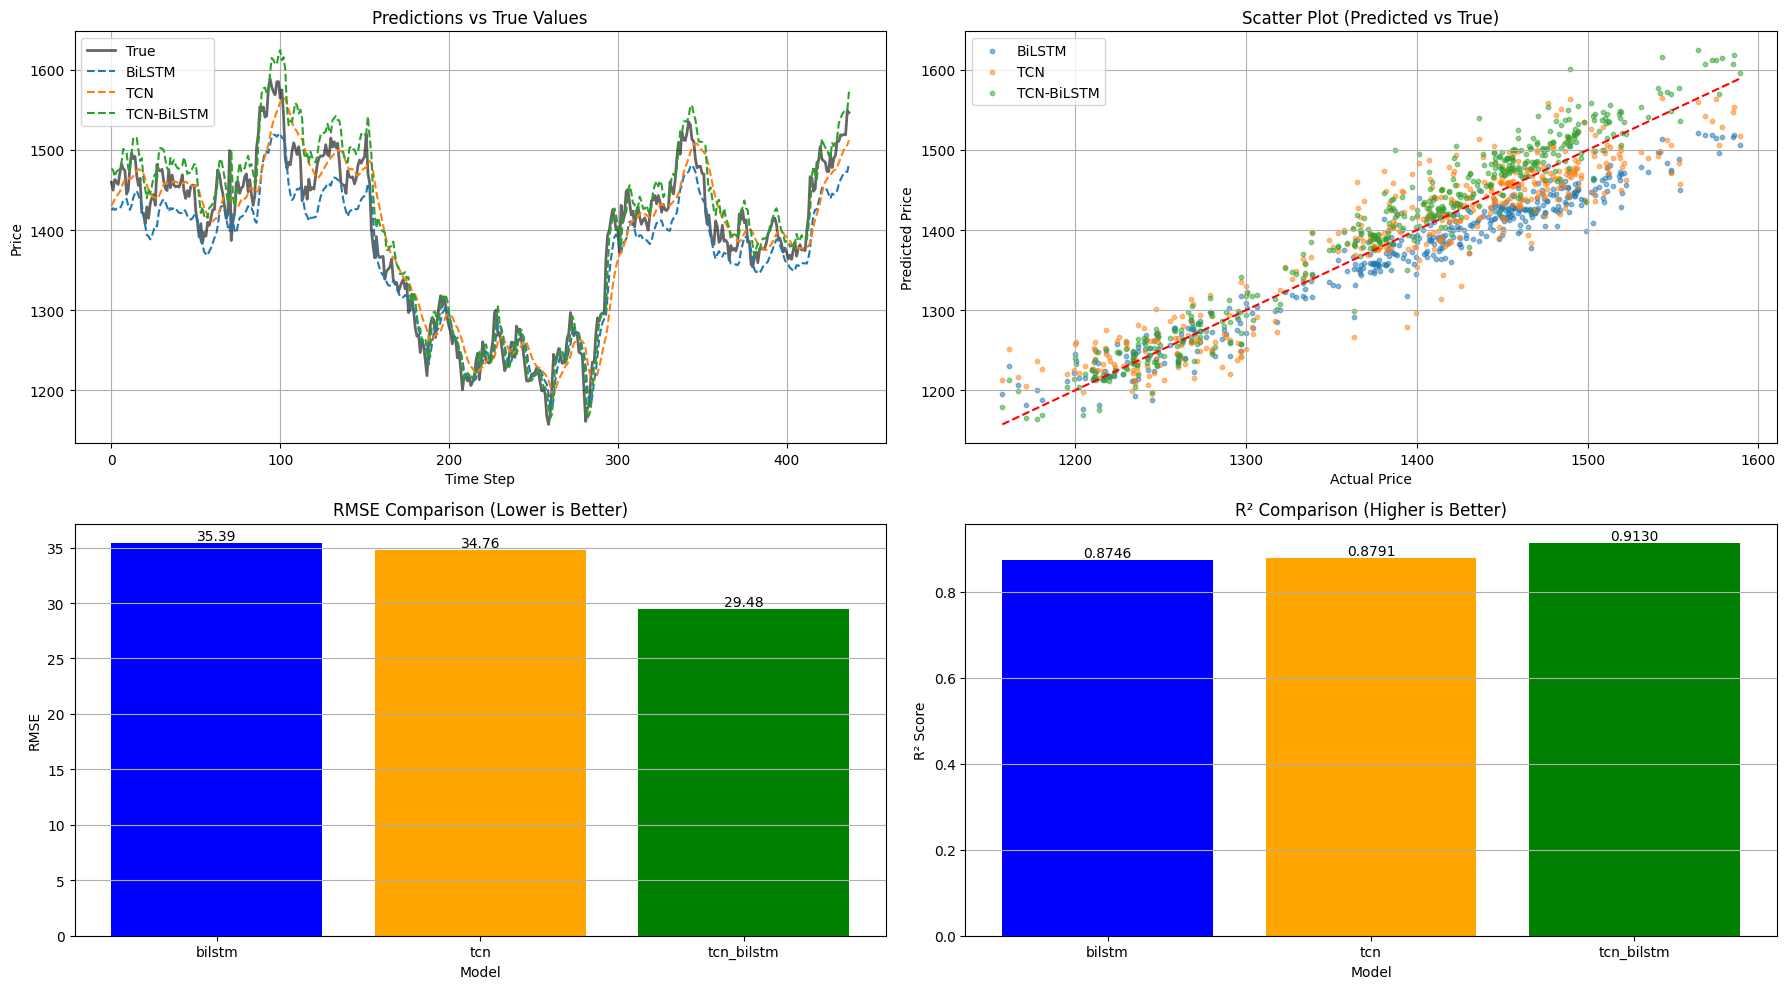

In [8]:
# NSE Stock Price Prediction Pipeline (Single Seed, No Averaging)
# Clean version — ONLY seed 29 is used
# All averaging logic removed
# Models: BiLSTM, TCN, TCN-BiLSTM trained ONCE each
# Only best-seed results and plots retained

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------
# Utility Functions
# ---------------------------------

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ---------------------------------
# File Paths
# ---------------------------------

def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    return {
        "old": f"{base}/data_harga_{s}.csv",
        "new": f"{base}/price_data_{s}.csv",
        "base": base,
    }

# ---------------------------------
# Fetch Price Data
# ---------------------------------

def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")

    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    print(f"Fetching {ticker} from yfinance: {start} -> {end}")
    t = yf.Ticker(ticker)
    try:
        df = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("Error fetching:", e)
        return pd.DataFrame()

    if df.empty:
        return df

    df = df.reset_index().rename(columns={"Date": "Date"})
    return df

# ---------------------------------
# Safe Load
# ---------------------------------

def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp["base"])

    if os.path.exists(cp["old"]):
        df = pd.read_csv(cp["old"])
        print("Loaded:", cp["old"])
        return df

    if os.path.exists(cp["new"]):
        df = pd.read_csv(cp["new"])
        print("Loaded:", cp["new"])
        return df

    df = fetch_price_yf(stock)

    if df.empty:
        print("yfinance FAILED -> generating synthetic fallback data")
        idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
        base_price = 100 + np.cumsum(np.random.randn(len(idx)) * 2)
        base_price = np.clip(base_price, 10, None)

        df = pd.DataFrame({
            "Date": idx,
            "Open": base_price * (1 + np.random.uniform(-0.02, 0.02, len(idx))),
            "High": base_price * (1 + np.random.uniform(0, 0.03, len(idx))),
            "Low": base_price * (1 - np.random.uniform(0, 0.03, len(idx))),
            "Close": base_price,
            "Volume": np.random.randint(1e6, 1e7, len(idx)),
        })
        df.to_csv(cp["new"], index=False)
        return df

    df.to_csv(cp["new"], index=False)
    return df

# ---------------------------------
# Preprocess
# ---------------------------------

def preprocess_price_data(df):
    cols = ["Open", "High", "Low", "Close", "Volume"]
    # Ensure columns exist
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Data missing columns: {missing}")

    df = df[cols].ffill().bfill()
    return df.reset_index(drop=True)

# ---------------------------------
# Windowing
# ---------------------------------

def make_windows(df, window, target_col="Close"):
    if target_col not in df.columns:
        target_col = "Close"

    cols = [target_col] + [c for c in df.columns if c != target_col]
    df = df[cols]
    data = df.values

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)


def make_tf_dataset(X, y, batch=32, shuffle=True, seed=29):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(1000, len(X)), seed=seed)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---------------------------------
# Positional Encoding
# ---------------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :tf.shape(x)[2]]

    def get_config(self):
        return super().get_config()

# ---------------------------------
# Models
# ---------------------------------

def build_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def tcn_block(x, filters, k=3, d=1, drop=0.2, final=False, seed=29):
    y = Conv1D(filters, k, padding='causal', dilation_rate=d)(x)
    y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(drop, seed=seed)(y)

    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out


def build_tcn(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    x = tcn_block(x, 64, 5, 1, 0.2, False, seed)
    x = tcn_block(x, 64, 3, 2, 0.2, False, seed)
    x = tcn_block(x, 32, 3, 4, 0.2, True, seed)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model


def build_tcn_bilstm(shape, seed=29):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN Branch
    t = tcn_block(x, 32, 5, 1, 0.2, False, seed)
    t = tcn_block(t, 32, 3, 2, 0.2, True, seed)

    # BiLSTM Branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Concatenate
    c = Concatenate()([t, b])
    c = Dense(32, activation="relu")(c)
    out = Dense(1)(c)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse",
                  metrics=["mae", "mse", rmse, calc_r2_score])
    return model

# ---------------------------------
# Train Single Seed (Seed 29)
# ---------------------------------

def train_single_seed(stock, window, batch, epochs,
                      X_train_s, y_train_s, X_val_s, y_val_s,
                      X_test_s, y_test_s, target_scaler, shape):

    seed = 29
    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_s, y_train_s, batch=batch, seed=seed)
    val_ds   = make_tf_dataset(X_val_s,   y_val_s,   batch=batch, shuffle=False)

    models = {
        "bilstm": build_bilstm(shape, seed),
        "tcn": build_tcn(shape, seed),
        "tcn_bilstm": build_tcn_bilstm(shape, seed),
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name.upper()}...")
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
            ]
        )

        y_pred_s = model.predict(X_test_s)
        y_true = target_scaler.inverse_transform(y_test_s).flatten()
        y_pred = target_scaler.inverse_transform(y_pred_s).flatten()

        mse = mean_squared_error(y_true, y_pred)

        results[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse,
            "rmse": math.sqrt(mse),
            "r2": r2_score(y_true, y_pred),
        }

    return models, results

# ---------------------------------
# Plotting (No Averaging)
# ---------------------------------

def plot_results(results, stock):
    # Print metrics clearly
    print("\n================ METRICS (Seed 29) ================")
    for name, r in results.items():
        print(f"\n{name.upper()}:")
        print(f"  MAE : {r['mae']:.4f}")
        print(f"  MSE : {r['mse']:.4f}")
        print(f"  RMSE: {r['rmse']:.4f}")
        print(f"  R²  : {r['r2']:.4f}")
    print("===================================================\n")

    # Fixed syntax here: removed double parens and trailing strings
    plt.figure(figsize=(18, 10))
    y_true = results["bilstm"]["y_true"] # All models share the same y_true

    # Time series
    ax = plt.subplot(2, 2, 1)
    ax.plot(y_true, label="True", linewidth=2, color='black', alpha=0.6)
    ax.plot(results["bilstm"]["y_pred"], label="BiLSTM", linestyle='--')
    ax.plot(results["tcn"]["y_pred"], label="TCN", linestyle='--')
    ax.plot(results["tcn_bilstm"]["y_pred"], label="TCN-BiLSTM", linestyle='--')
    ax.set_title("Predictions vs True Values")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

    # Scatter
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(y_true, results["bilstm"]["y_pred"], alpha=0.5, label="BiLSTM", s=10)
    ax2.scatter(y_true, results["tcn"]["y_pred"], alpha=0.5, label="TCN", s=10)
    ax2.scatter(y_true, results["tcn_bilstm"]["y_pred"], alpha=0.5, label="TCN-BiLSTM", s=10)
    lim = [y_true.min(), y_true.max()]
    ax2.plot(lim, lim, 'r--')
    ax2.set_title("Scatter Plot (Predicted vs True)")
    ax2.set_xlabel("Actual Price")
    ax2.set_ylabel("Predicted Price")
    ax2.legend()
    ax2.grid(True)

    # RMSE bar
    ax3 = plt.subplot(2, 2, 3)
    models = ["bilstm", "tcn", "tcn_bilstm"]
    rmse_vals = [results[m]["rmse"] for m in models]
    bars = ax3.bar(models, rmse_vals, color=['blue', 'orange', 'green'])
    ax3.bar_label(bars, fmt='%.2f')
    ax3.set_title("RMSE Comparison (Lower is Better)")
    ax3.set_xlabel("Model")
    ax3.set_ylabel("RMSE")
    ax3.grid(True, axis='y')

    # R² bar
    ax4 = plt.subplot(2, 2, 4)
    r2_vals = [results[m]["r2"] for m in models]
    bars = ax4.bar(models, r2_vals, color=['blue', 'orange', 'green'])
    ax4.bar_label(bars, fmt='%.4f')
    ax4.set_title("R² Comparison (Higher is Better)")
    ax4.set_xlabel("Model")
    ax4.set_ylabel("R² Score")
    ax4.grid(True, axis='y')

    plt.tight_layout()
    ensure_dir(f"prediction/{stock}")
    plt.savefig(f"prediction/{stock}/comparison_single_seed.png", dpi=300)
    print(f"Plot saved to prediction/{stock}/comparison_single_seed.png")
    # plt.show() # Commented out for non-interactive envs

# ---------------------------------
# Main
# ---------------------------------

if __name__ == "__main__":
    STOCKS = ["reliance"]
    WINDOW = 20
    BATCH = 32
    EPOCHS = 200

    for stock in STOCKS:
        print(f"--- Processing {stock} ---")
        df = safe_load_price(stock)
        df = preprocess_price_data(df)

        ensure_dir(f"prediction/{stock}")
        ensure_dir(f"saved_models/{stock}")

        X, y = make_windows(df, WINDOW)

        n = len(X)
        t1 = int(0.7 * n)
        t2 = int(0.85 * n)

        X_train, y_train = X[:t1], y[:t1]
        X_val,   y_val    = X[t1:t2], y[t1:t2]
        X_test,  y_test   = X[t2:],   y[t2:]

        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        X_train_s = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        y_train_s = target_scaler.fit_transform(y_train)

        X_val_s = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        y_val_s = target_scaler.transform(y_val)

        X_test_s = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        y_test_s = target_scaler.transform(y_test)

        shape = (WINDOW, X.shape[2])

        models, results = train_single_seed(
            stock, WINDOW, BATCH, EPOCHS,
            X_train_s, y_train_s, X_val_s, y_val_s,
            X_test_s, y_test_s, target_scaler, shape
        )

        # Save models
        for name, model in models.items():
            save_path = f"saved_models/{stock}/{name}_seed29"
            ensure_dir(save_path)
            model.save(f"{save_path}/model.keras")

        # Save predictions
        for name, r in results.items():
            pd.DataFrame({
                "y_true": r["y_true"],
                "y_pred": r["y_pred"]
            }).to_csv(f"prediction/{stock}/{name}_predictions_seed29.csv", index=False)

        plot_results(results, stock)

    print("\n✓ DONE — Single-seed training (seed=29) completed.")